## Create a DataFrame from the Trove dataset

### Obtaining the data

You can download the whole Trove dataset using:

`wget --recursive --no-parent http://overproof.projectcomputing.com/datasets/`

Change the parent directory `overproof.projectcomputing.com` to a friendlier name `trove_overproof`.

### Preprocessing of the data

In [1]:
from glob import glob
import jellyfish
import numpy as np
import os
import pandas as pd
import re

In [ ]:
# Dictionary with the following structure:
# arbitrary_dirname: path_to_txt_files
# dirname is an arbitrary name which can be used to filter the DB in later steps

dict_dirnames = {
    "trove_dataset_1": './trove_overproof/datasets/dataset1/rawTextAndHumanCorrectionPairs',
    "trove_dataset_2": './trove_overproof/datasets/dataset2/rawTextAndHumanCorrectionAndOverproofCorrectionTriples',
    "trove_dataset_3": './trove_overproof/datasets/dataset3/rawTextAndHumanCorrectionAndOverproofCorrectionTriples'
}

In [ ]:
df = pd.DataFrame(columns=["filePath", "articleId", "articleType", "year", 
                           "ocrText", "humanText", "corrected"])

In [ ]:
def process_header(line):
    re_header = r'^\*\$\*OVERPROOF\*\$\*\s*([0-9]+)\s+year\s+([0-9]{4})\s+type\s(.+)\s+title\s+.+$'
    if re.match(re_header, line):
        articleId, year, articleType = re.match(re_header, line).groups()
        return articleId, year, articleType

In [ ]:
def process_content(article_content):
    ocr_line = []
    human_line = []
    hcorr_line = []
    for line in article_content:
        line = line.split("||@@||")
        if (not line[0].strip() == '') or (not line[1].strip() == ''):
            if len(line) == 3:
                ocr_line.append(line[0].strip())
                human_line.append(line[1].strip())
                hcorr_line.append(line[2].strip())
            if len(line) == 2:
                ocr_line.append(line[0].strip())
                human_line.append(line[1].strip())

    return " ".join(ocr_line), " ".join(human_line), " ".join(hcorr_line)

In [ ]:
article_content = []
year = ""
file_path = ""
articleId = ""
articleType = ""
processed_content = ""
article_counter = 0
for ldir in dict_dirnames.keys():
    list_files = glob(os.path.join(dict_dirnames[ldir], "*.txt"))
    for lfile in list_files:
        file_path = lfile
        fio = open(lfile, "r")
        flines = fio.readlines()
        for iline in range(len(flines)):
            if flines[iline].startswith('*$*OVERPROOF*$*'):
                articleId, year, articleType = process_header(flines[iline])
                article_counter += 1
            else:
                article_content.append(flines[iline])
                if ((len(flines) -1 == iline) or (flines[iline + 1].startswith('*$*OVERPROOF*$*'))):
                    processed_content = process_content(article_content)

                    # Insert into dataframe:
                    df.loc[article_counter] = [file_path, 
                                               articleId,
                                               articleType,
                                               year,
                                               processed_content[0],
                                               processed_content[1],
                                               processed_content[2]
                                              ] 
                    
                    # Clean variables:
                    year = ""
                    articleId = ""
                    articleType = ""
                    processed_content = ""
                    article_content = []

print(article_counter)

In [ ]:
df

### Add string similarity and length

In [ ]:
from pandarallel import pandarallel
# Initialization
pandarallel.initialize()

In [ ]:
def distance_via_levenshtein(gs_clean, ocr_clean):
    gs_clean = gs_clean.lower()
    ocr_clean = ocr_clean.lower()
    max_sentlength = max(len(gs_clean), len(ocr_clean))
    lev_distance = jellyfish.levenshtein_distance(gs_clean, ocr_clean)
    dist_similarity = (max_sentlength - lev_distance) / float(max_sentlength)
    return dist_similarity

In [ ]:
df['str_similarity'] = df.parallel_apply(lambda row: distance_via_levenshtein(row['ocrText'], row['humanText']), axis=1)
df['str_length_humanText'] = df.parallel_apply(lambda row: len(row['humanText']), axis=1)
df['str_length_ocrText'] = df.parallel_apply(lambda row: len(row['ocrText']), axis=1)


In [ ]:
# Number of documents that have at least one article with string similarity lower than 0.8:
len(df[df['str_similarity'] < 0.8]['articleId'].unique())

In [ ]:
def quality(similarity):
    if similarity > 0.9:
        return 1 # good
    elif similarity > 0.8:
        return 2 # soso
    elif similarity > 0.7:
        return 3 # bad
    return 4 # ugly

df['quality_band'] = df["str_similarity"].apply(quality)

In [ ]:
df['quality_band'].value_counts()

### OCR and GS string similarity distribution

Plot the distribution of sentences according to string similarity between OCR and GS text:

In [ ]:
df[['str_similarity']].plot(kind='hist',bins=np.arange(0, 1.1, 0.1),rwidth=0.8)

Get some examples from each bin:

In [ ]:
df[(df['str_similarity'] > 0.7) & (df['str_similarity'] <= 0.8)].sample(6).loc[:, ['ocrText', 'humanText']]

In [ ]:
df.to_pickle("db_trove.pkl")

In [ ]:
trovedf = df

dExamples = dict()
for i in np.arange(0.1, 1.1, 0.1):
    tempdf = trovedf[(trovedf['str_similarity'] > (i - 0.1)) & (trovedf['str_similarity'] <= i) & (abs(trovedf['ocrText'].str.len() - trovedf['humanText'].str.len()) <= 100)]
    if tempdf.shape[0] >= 1:
        dExamples[((i - 0.1, i))] = (tempdf.shape[0], tempdf.iloc[0].filePath, tempdf.iloc[0].ocrText, tempdf.iloc[0].humanText)

for example in dExamples:
    print("Range:", example)
    print("Number of articles:", dExamples[example][0])
    print("Example: ./" + dExamples[example][1])
    print("\nOCR text:")
    print(dExamples[example][2])
    print("\nHuman-corrected text:")
    print(dExamples[example][3])
    print()
    print('==========')
    print()

# Dictionary lookup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import syntok.segmenter as segmenter

In [3]:
df = pd.read_pickle("db_trove.pkl")
df.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected,str_similarity,str_length_humanText,str_length_ocrText,quality_band
1,./trove_overproof/datasets/dataset1/rawTextAnd...,18378453,Article ILLUSTRATED,1953,"FROM RIVER CROSSING TO END OF TRIÄÜ I ^PI A^H""...",FROM RIVER CROSSING TO END OF TRIAL SPLASH: Pe...,,0.847561,746,820,2
2,./trove_overproof/datasets/dataset1/rawTextAnd...,18363627,Article,1953,"Natural Childbirth Sir,-We nurses have seen fa...","Natural Childbirth Sir,-We nurses have seen fa...",,0.964119,641,630,1
3,./trove_overproof/datasets/dataset1/rawTextAnd...,18366055,Article,1953,FIRST CHURCH I SERVICE 1 Presbyterian I ' Anni...,FIRST CHURCH SERVICE Presbyterian Anniversary ...,,0.738901,946,832,3
4,./trove_overproof/datasets/dataset1/rawTextAnd...,18386137,Article,1953,"""Bob"" Lulham's Fight Against Thallium District...","""Bob"" Lulham's Fight Against Thallium Arthur ...",,0.493898,2950,2740,4
5,./trove_overproof/datasets/dataset1/rawTextAnd...,18368961,Article,1953,"DIVORCE Before The Judge In Divorce, Mr Justic...","DIVORCE Before The Judge In Divorce, Mr. Justi...",,0.894176,1219,1121,2


In [4]:
corrected_cond = (df["corrected"] == '')# & (df["str_length_humanText"] > 10)

In [5]:
df["use_corrected"] = 1
df.loc[corrected_cond, 'corrected'] = df.loc[corrected_cond, 'humanText']
df.loc[corrected_cond, 'use_corrected'] = 0
df['use_corrected'].value_counts()

0    30301
1      208
Name: use_corrected, dtype: int64

In [6]:
ocr_corr_diff = abs(df['ocrText'].str.len() - df['corrected'].str.len())
ocr_corr_diff /= np.maximum(df['ocrText'].str.len().values, df['corrected'].str.len().values)
ocr_corr_diff *= 100.

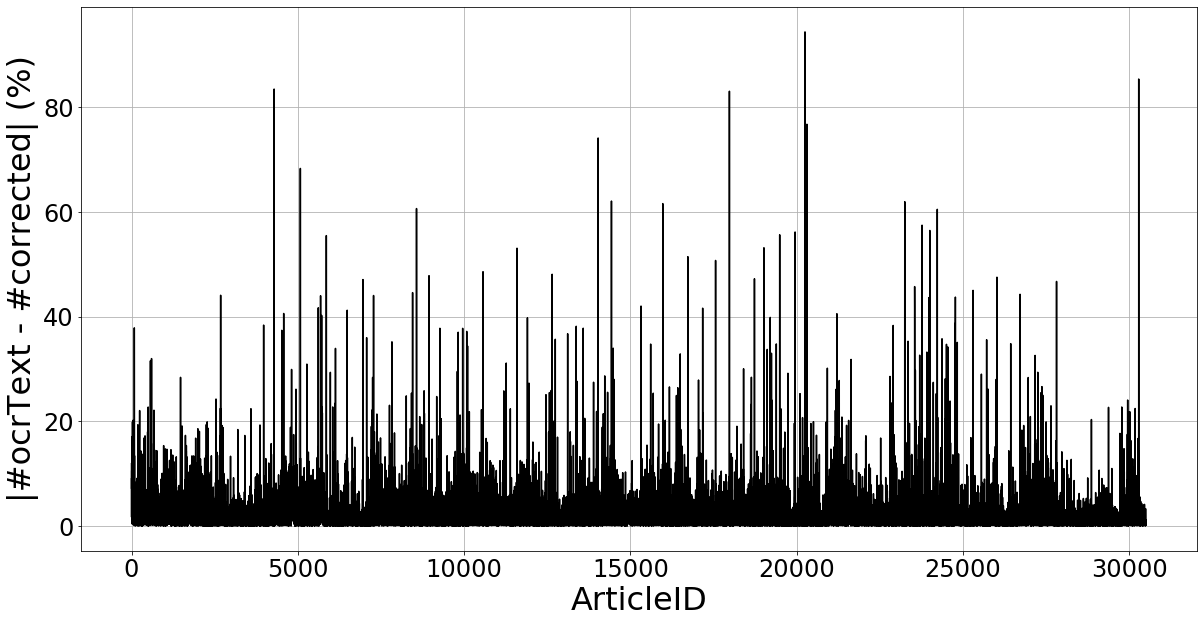

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(ocr_corr_diff, c='k')
plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.xlabel("ArticleID", size=32)
plt.ylabel("|#ocrText - #corrected| (%)", size=32)
plt.show()

#Articles with character difference lower than 10.00%: 29697, percentage: 97.34%


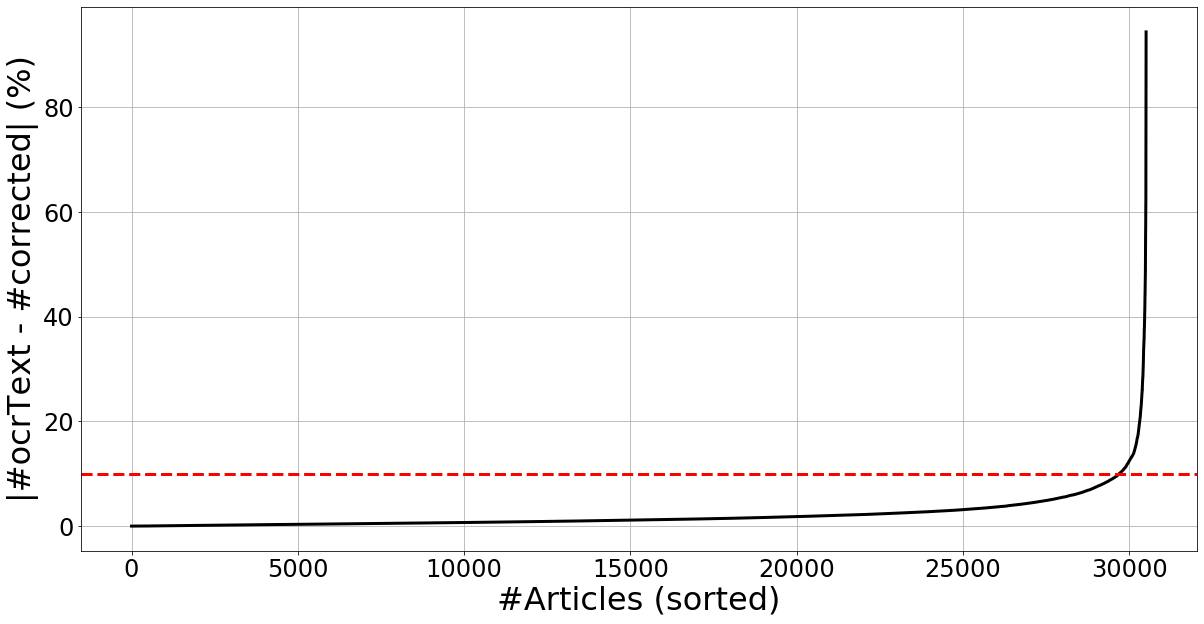

In [8]:
plt.figure(figsize=(20, 10))

perc_diff = 10.

plt.plot(np.sort(ocr_corr_diff), c='k', lw=3)

plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.xlabel("#Articles (sorted)", size=32)
plt.ylabel("|#ocrText - #corrected| (%)", size=32)
plt.axhline(perc_diff, 0, 1, color='r', ls='--', lw=3)
print("#Articles with character difference lower than %.2f%%: %i, percentage: %.2f%%" % (perc_diff, len(ocr_corr_diff[ocr_corr_diff <= perc_diff]), len(ocr_corr_diff[ocr_corr_diff <= perc_diff])/len(ocr_corr_diff)*100.))
plt.show()

In [9]:
# spacy to do most of the pre-processing
import spacy
# see: https://spacy.io/universe/project/spacy-langdetect
from spacy_langdetect import LanguageDetector

# preprocessing
# Load a spacy model
nlp = spacy.load('en_core_web_lg')
# spacy_dict will be later used for the "Dictionary lookup" evaluation
spacy_dict = list(nlp.vocab.strings)

In [10]:
def dictionary_lookup(myrow, colname="corrected"):
    #print(myrow.name, end=" ")
    
    sent_list = []
    found_dict = []
    
    for paragraph in segmenter.analyze(myrow[colname]):
        for sentence in paragraph:
            all_tokens = []
            all_txt_dict = []
            for token in sentence:
                # exactly reproduce the input
                # and do not remove "imperfections"
                # print(token.spacing, token.value, sep='', end='')
                all_tokens.append(token.value)
                if token.value.lower() in spacy_dict:
                    all_txt_dict.append(str(len(token.value)))
                else:
                    all_txt_dict.append(str(-len(token.value)))
            sent_list.append(all_tokens)
            found_dict.append(all_txt_dict)
            #found_dict.append([])
    return sent_list, found_dict

In [ ]:
df.to_pickle("db_trove_before_sentencizer.pkl")

In [11]:
from pandarallel import pandarallel
# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data tranfer (pipe) to transfer data between the main process and workers.


In [12]:
df['corrected_sentencizer'] = ''
df['corrected_dict_lookup'] = ''

df['ocr_sentencizer'] = ''
df['ocr_dict_lookup'] = ''

In [13]:
df['corrected_sentencizer'], df['corrected_dict_lookup'] = zip(*df.parallel_apply(dictionary_lookup, args=["corrected"], axis=1))


In [14]:
df['ocr_sentencizer'], df['ocr_dict_lookup'] = zip(*df.parallel_apply(dictionary_lookup, args=["ocrText"], axis=1))


In [15]:
df.to_pickle("db_trove_sentence_with_lookup.pkl")

In [16]:
df.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected,str_similarity,str_length_humanText,str_length_ocrText,quality_band,use_corrected,corrected_sentencizer,corrected_dict_lookup,ocr_sentencizer,ocr_dict_lookup
1,./trove_overproof/datasets/dataset1/rawTextAnd...,18378453,Article ILLUSTRATED,1953,"FROM RIVER CROSSING TO END OF TRIÄÜ I ^PI A^H""...",FROM RIVER CROSSING TO END OF TRIAL SPLASH: Pe...,FROM RIVER CROSSING TO END OF TRIAL SPLASH: Pe...,0.847561,746,820,2,0,"[[FROM, RIVER, CROSSING, TO, END, OF, TRIAL, S...","[[4, 5, 8, 2, 3, 2, 5, 6, 1, -5, -6, 8, 4, 4, ...","[[FROM, RIVER, CROSSING, TO, END, OF, TRIÄÜ, I...","[[4, 5, 8, 2, 3, 2, -5, 1, 1, 2, -3, 1, -5, -6..."
2,./trove_overproof/datasets/dataset1/rawTextAnd...,18363627,Article,1953,"Natural Childbirth Sir,-We nurses have seen fa...","Natural Childbirth Sir,-We nurses have seen fa...","Natural Childbirth Sir,-We nurses have seen fa...",0.964119,641,630,1,0,"[[Natural, Childbirth, Sir,-We, nurses, have, ...","[[7, 10, -7, 6, 4, 4, 3, 3, 4, 5, 6, 4, 6, 5, ...","[[Natural, Childbirth, Sir,-We, nurses, have, ...","[[7, 10, -7, 6, 4, 4, 3, 3, 4, 5, 6, 4, 6, 5, ..."
3,./trove_overproof/datasets/dataset1/rawTextAnd...,18366055,Article,1953,FIRST CHURCH I SERVICE 1 Presbyterian I ' Anni...,FIRST CHURCH SERVICE Presbyterian Anniversary ...,FIRST CHURCH SERVICE Presbyterian Anniversary ...,0.738901,946,832,3,0,"[[FIRST, CHURCH, SERVICE, Presbyterian, Annive...","[[5, 6, 7, 12, 11, 3, 5, 11, 2, 3, 5, 12, 6, 7...","[[FIRST, CHURCH, I, SERVICE, 1, Presbyterian, ...","[[5, 6, 1, 7, 1, 12, 1, 1, 11, 1, 3, 5, -12, 3..."
4,./trove_overproof/datasets/dataset1/rawTextAnd...,18386137,Article,1953,"""Bob"" Lulham's Fight Against Thallium District...","""Bob"" Lulham's Fight Against Thallium Arthur ...","""Bob"" Lulham's Fight Against Thallium Arthur ...",0.493898,2950,2740,4,0,"[["", Bob, "", Lulham, 's, Fight, Against, Thall...","[[1, 3, 1, -6, 2, 5, 7, 8, 6, 6, 1, 1, 3, 1, 1...","[["", Bob, "", Lulham, 's, Fight, Against, Thall...","[[1, 3, 1, -6, 2, 5, 7, 8, 8, 8, 1], [4, 5, 6,..."
5,./trove_overproof/datasets/dataset1/rawTextAnd...,18368961,Article,1953,"DIVORCE Before The Judge In Divorce, Mr Justic...","DIVORCE Before The Judge In Divorce, Mr. Justi...","DIVORCE Before The Judge In Divorce, Mr. Justi...",0.894176,1219,1121,2,0,"[[DIVORCE, Before, The, Judge, In, Divorce, ,,...","[[7, 6, 3, 5, 2, 7, 1, 2, 1, 7, -5, 7, 4, 1, 1...","[[DIVORCE, Before, The, Judge, In, Divorce, ,,...","[[7, 6, 3, 5, 2, 7, 1, 2, 7, -5, 7, 4, 1, 1, -..."
